In [2]:
import torch
batch = torch.rand((2, 3, 4, 5))
batch

tensor([[[[0.1428, 0.1380, 0.7761, 0.7043, 0.3284],
          [0.0275, 0.4760, 0.4247, 0.2694, 0.8616],
          [0.8617, 0.3963, 0.2129, 0.5479, 0.1290],
          [0.5568, 0.5041, 0.3911, 0.1071, 0.0406]],

         [[0.6774, 0.9870, 0.0100, 0.9261, 0.8378],
          [0.7626, 0.3761, 0.4476, 0.3454, 0.1428],
          [0.6440, 0.9156, 0.3636, 0.4725, 0.7698],
          [0.0143, 0.0043, 0.1467, 0.9025, 0.5773]],

         [[0.4308, 0.3229, 0.5736, 0.4909, 0.1528],
          [0.1918, 0.9678, 0.7669, 0.3730, 0.8868],
          [0.7376, 0.4519, 0.7915, 0.8447, 0.9203],
          [0.7017, 0.6698, 0.1260, 0.3930, 0.5504]]],


        [[[0.9966, 0.9064, 0.8597, 0.3244, 0.5952],
          [0.6741, 0.6204, 0.2834, 0.9115, 0.7165],
          [0.9500, 0.8970, 0.3959, 0.0242, 0.9854],
          [0.2317, 0.2555, 0.8173, 0.1843, 0.4162]],

         [[0.0483, 0.4422, 0.3116, 0.2981, 0.1002],
          [0.0612, 0.9904, 0.2475, 0.7924, 0.3086],
          [0.0593, 0.7153, 0.3680, 0.6119, 0.8817],
  

In [3]:
def get_normalize(features: torch.Tensor):
    means = features.mean(dim=(0, 2, 3))
    stds = features.std(dim=(0, 2, 3))

    return means, stds

In [4]:
get_normalize(batch)

(tensor([0.4986, 0.5019, 0.5688]), tensor([0.3049, 0.3188, 0.2497]))

In [5]:
import torchvision.transforms as T

def get_augmentations(train: bool = True, means = None, stds = None) -> T.Compose:
    if train:
        t = T.Compose(
            [
                T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomAdjustSharpness(sharpness_factor=2),
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )
        return t
    t = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
    )
    return t

    
    

In [6]:
get_augmentations(False)

Compose(
    ToTensor()
    Normalize(mean=None, std=None)
)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()

    prediction = []

    for x, _ in loader:
        output = model(x.to(device)).cpu()

        prediction.append(torch.argmax(output, dim=1))

    prediction = torch.cat(prediction)

    return prediction

In [8]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


def train(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn,
    device: torch.device,
) -> (float, float):
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


@torch.inference_mode()
def evaluate(
    model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> (float, float):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


def plot_stats(
    train_loss: [float],
    valid_loss: [float],
    train_accuracy: [float],
    valid_accuracy: [float],
    title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + f" accuracy {valid_accuracy}")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()


def whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break


def main(func, threshold, title):
    set_seed(0xDEADF00D)

    dataset = CIFAR10("cifar10", train=True, download=True, transform=T.ToTensor())

    means = (dataset.data / 255).mean(axis=(0, 1, 2))
    stds = (dataset.data / 255).std(axis=(0, 1, 2))

    train_transforms = T.Compose(
        [
            T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomAdjustSharpness(sharpness_factor=2),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds),
        ]
    )

    test_transforms = T.Compose([T.ToTensor(), T.Normalize(mean=means, std=stds)])

    dataset_train = CIFAR10(
        "cifar10", train=True, download=True, transform=train_transforms
    )
    dataset_valid = CIFAR10(
        "cifar10", train=False, download=True, transform=test_transforms
    )

    train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = func().to(device)

    optimizer = Adam(model.parameters(), lr=1e-3)

    loss_fn = nn.CrossEntropyLoss()

    whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, device, threshold, title
    )

    torch.save(predict(model, valid_loader, device), "prediction.pt")

def create_simple_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # 32 x 32 x 16
        nn.ReLU(),

        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # 16 x 16 x 32
        nn.ReLU(),

        nn.MaxPool2d(2),  # 8 x 8 x 32

        nn.Flatten(),

        nn.Linear(8 * 8 * 32, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

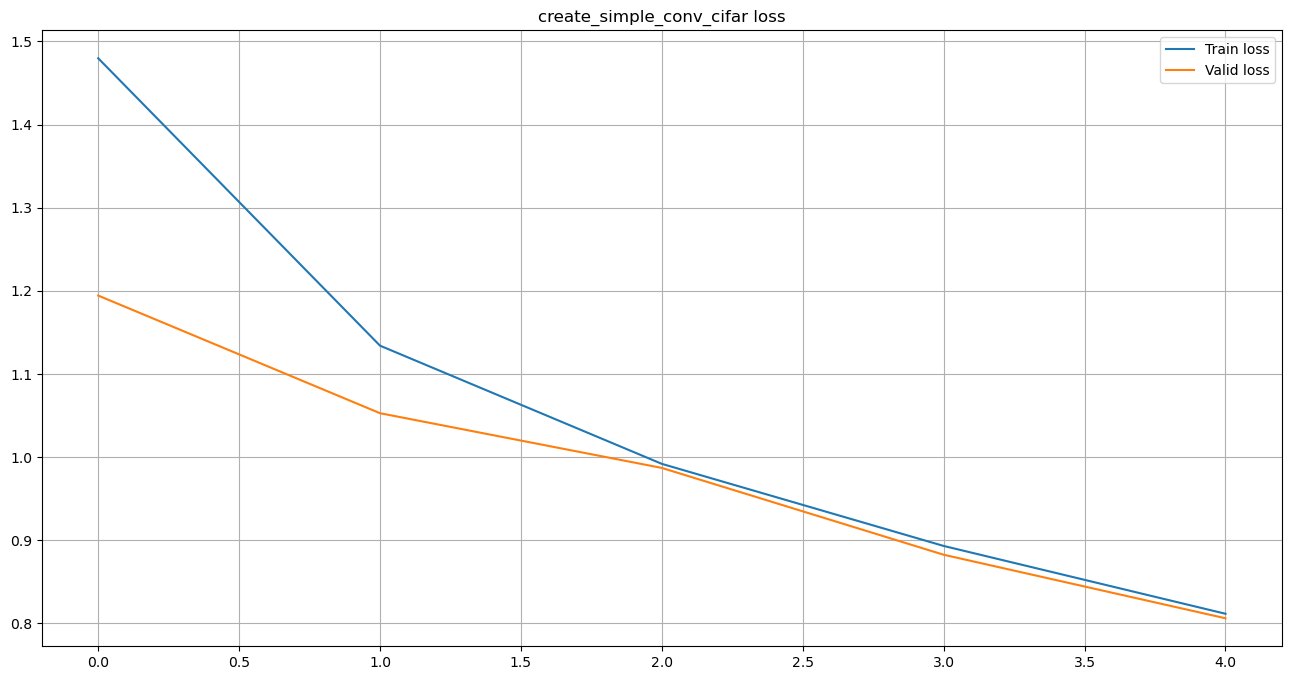

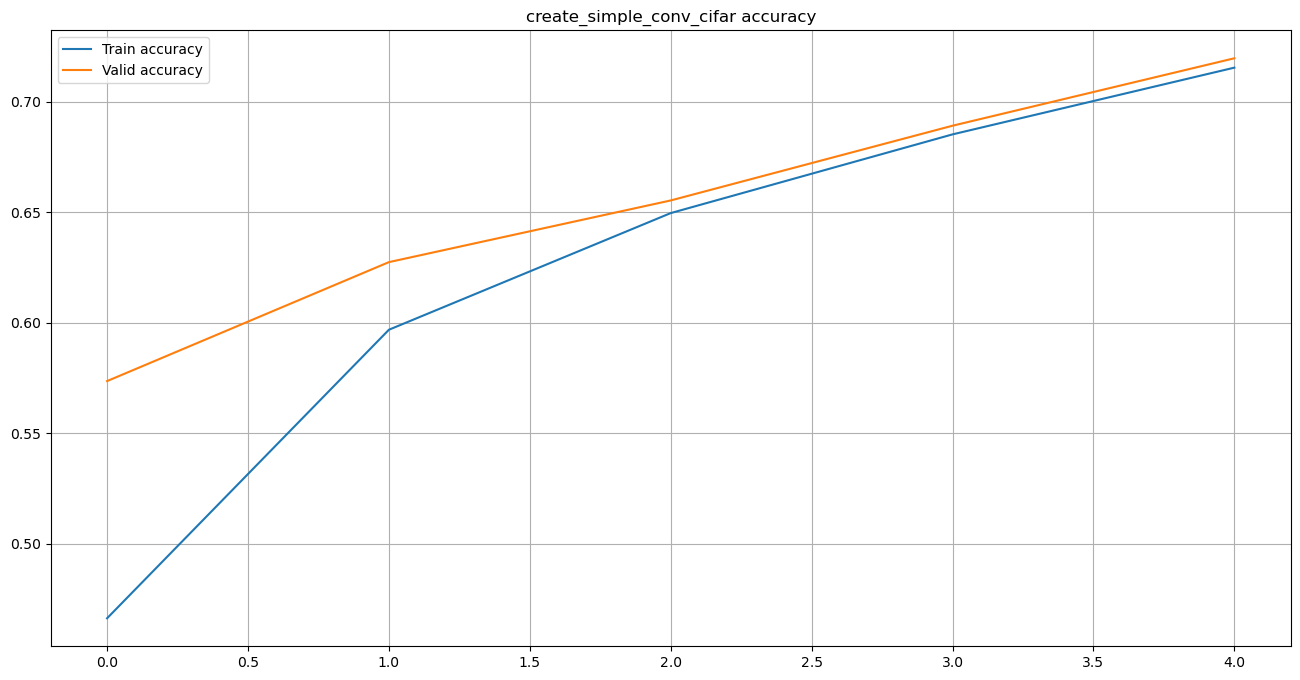

In [9]:
main(create_simple_conv_cifar, 0.7, 'create_simple_conv_cifar')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda
Tesla T4


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()

    prediction = []

    for iteration in range(iterations):
        single_prediction = []

        for x, _ in loader:
            output = model(x.to(device))

            single_prediction.append(output)

        prediction.append(torch.vstack(single_prediction))

    prediction = torch.argmax(torch.mean(torch.stack(prediction), dim=0), dim=1)

    return prediction

In [12]:
from torch.optim.lr_scheduler import StepLR


def whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break


In [13]:
import torch.nn as nn


def create_advanced_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Flatten(),

        nn.Linear(4 * 4 * 128, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 100)
    )

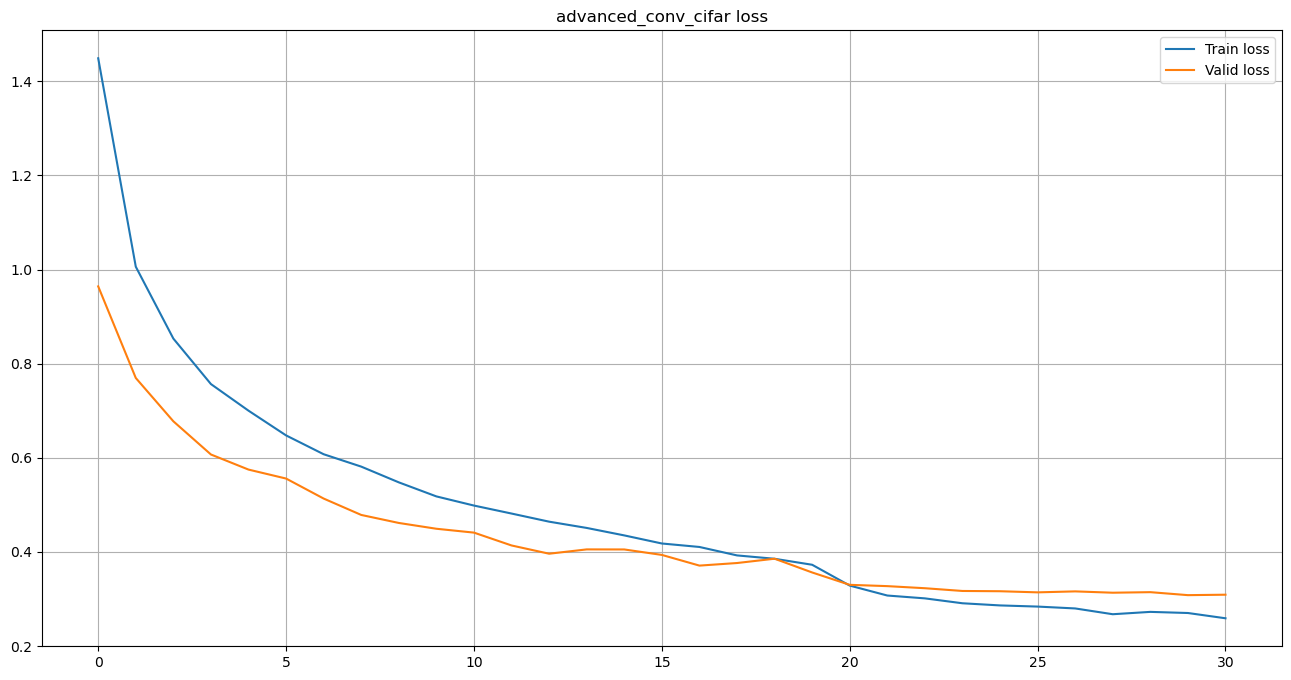

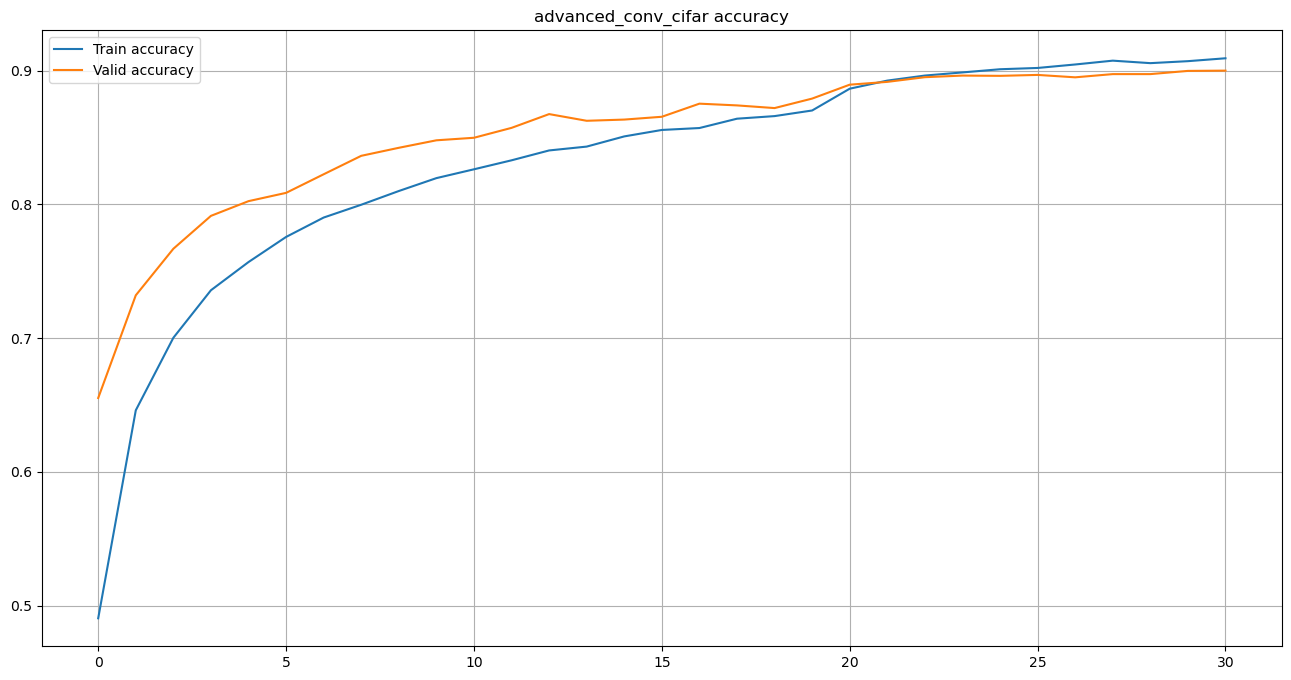

Files already downloaded and verified


In [14]:
title = 'advanced_conv_cifar'
threshold = 0.9

set_seed(0xDEADF00D)

dataset = CIFAR10("cifar10", train=True, download=True, transform=T.ToTensor())

means = (dataset.data / 255).mean(axis=(0, 1, 2))
stds = (dataset.data / 255).std(axis=(0, 1, 2))

train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds),
    ]
)

test_transforms = T.Compose([T.ToTensor(), T.Normalize(mean=means, std=stds)])

dataset_train = CIFAR10(
    "cifar10", train=True, download=True, transform=train_transforms
)
dataset_valid = CIFAR10(
    "cifar10", train=False, download=True, transform=test_transforms
)

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_advanced_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
)

torch.save(model.state_dict(), "model.pt")

dataset_valid_tta = CIFAR10("cifar10", train=False, download=True, transform=train_transforms)
valid_tta_loader = DataLoader(dataset_valid_tta, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

torch.save(predict_tta(model, valid_tta_loader, device, iterations=20), "prediction_tta.pt")


In [15]:
data = CIFAR10('/home/jupyter/mnt/datasets/cifar10', download=True, transform=T.ToTensor())
targets = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /home/jupyter/mnt/datasets/cifar10/cifar-10-python.tar.gz to /home/jupyter/mnt/datasets/cifar10


In [20]:
def check_cifar(x: int):
    i = data[x][0]
    j = data[x][1]
    transform = T.ToPILImage()
    i = torch.unsqueeze(i, 0).to("cuda")
    output = model(i)
    _, y_pred = torch.max(output, 1)
    plt.figure(figsize=(2, 2))
    plt.imshow(transform(data[x][0]))
    plt.title(f'{targets[int(y_pred)]}, but should be {targets[j]}')
    plt.show()

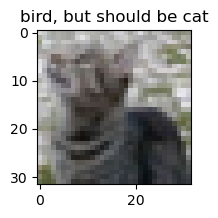

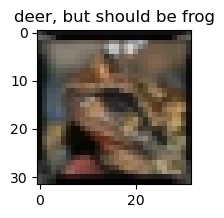

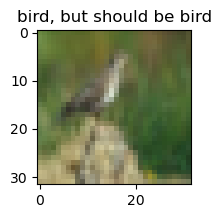

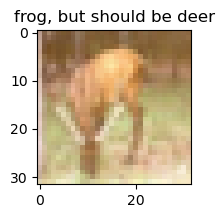

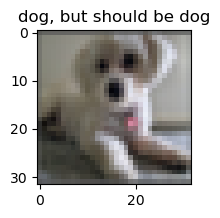

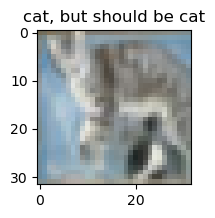

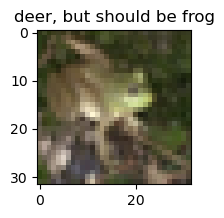

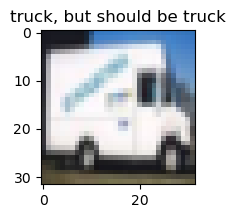

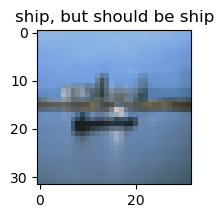

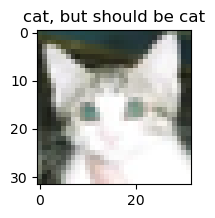

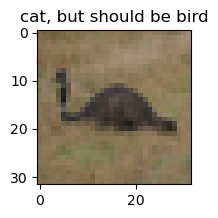

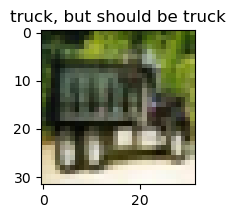

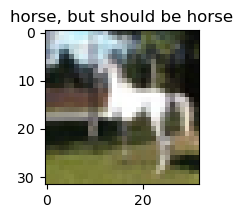

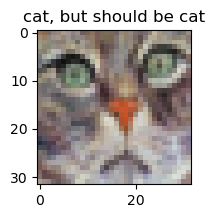

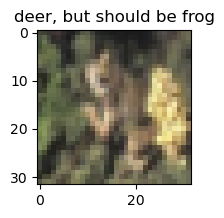

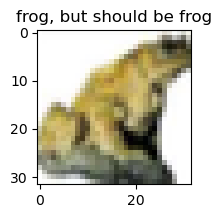

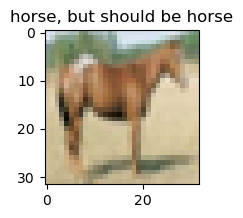

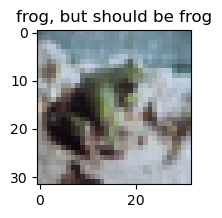

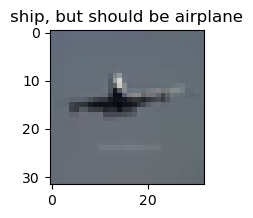

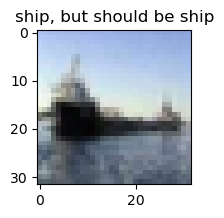

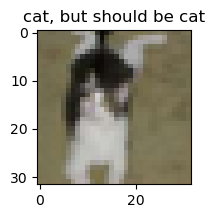

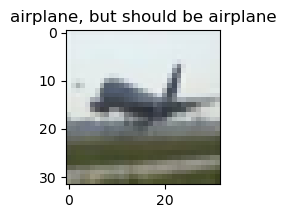

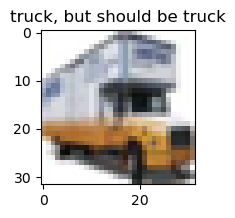

In [21]:
for x in range(333,10000,437):
   check_cifar(x)

### Added skip-connection

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block8 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.block1(x)

        x = self.block2(x) + x

        x = self.block3(x)

        x = self.block4(x) + x

        x = self.block5(x)

        x = self.block6(x) + x

        x = self.block7(x) + x

        x = self.block8(x)

        return x

    
def create_advanced_skip_connection_conv_cifar():
    return Model()

In [24]:
def whole_train_valid_cycle(
    model,
    train_loader,
    valid_loader,
    optimizer,
    loss_fn,
    scheduler,
    device,
    threshold,
    title,
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break

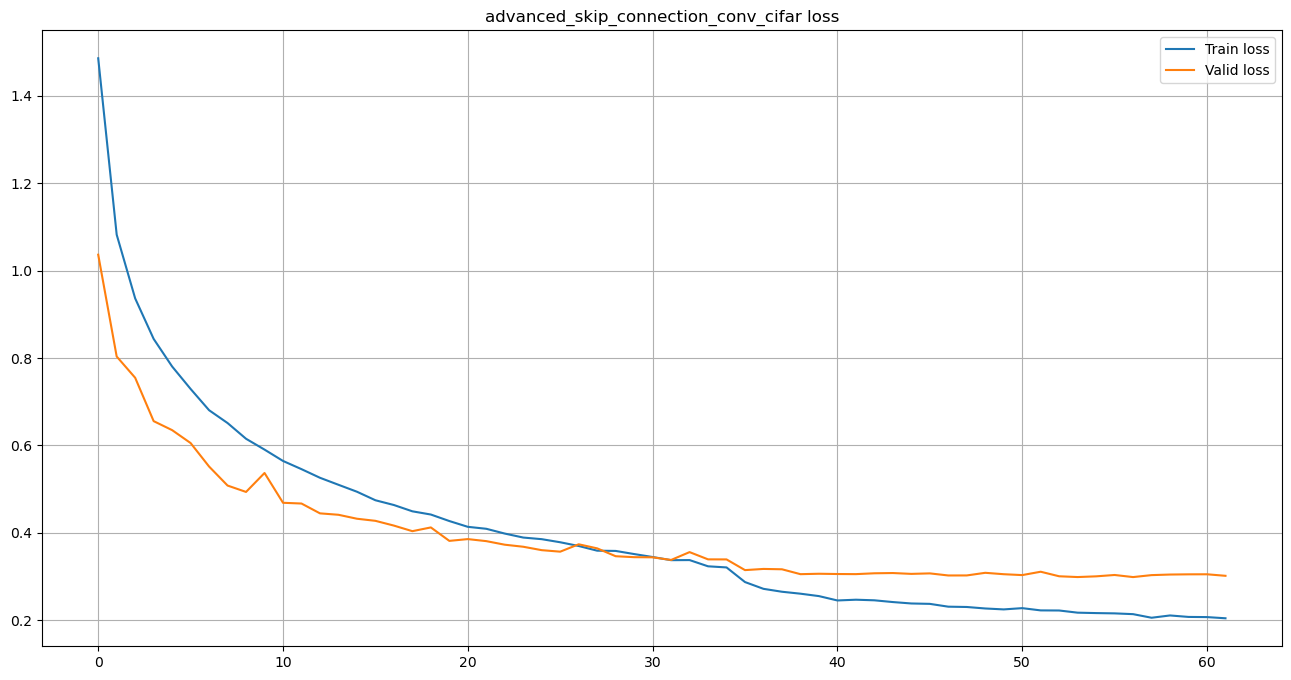

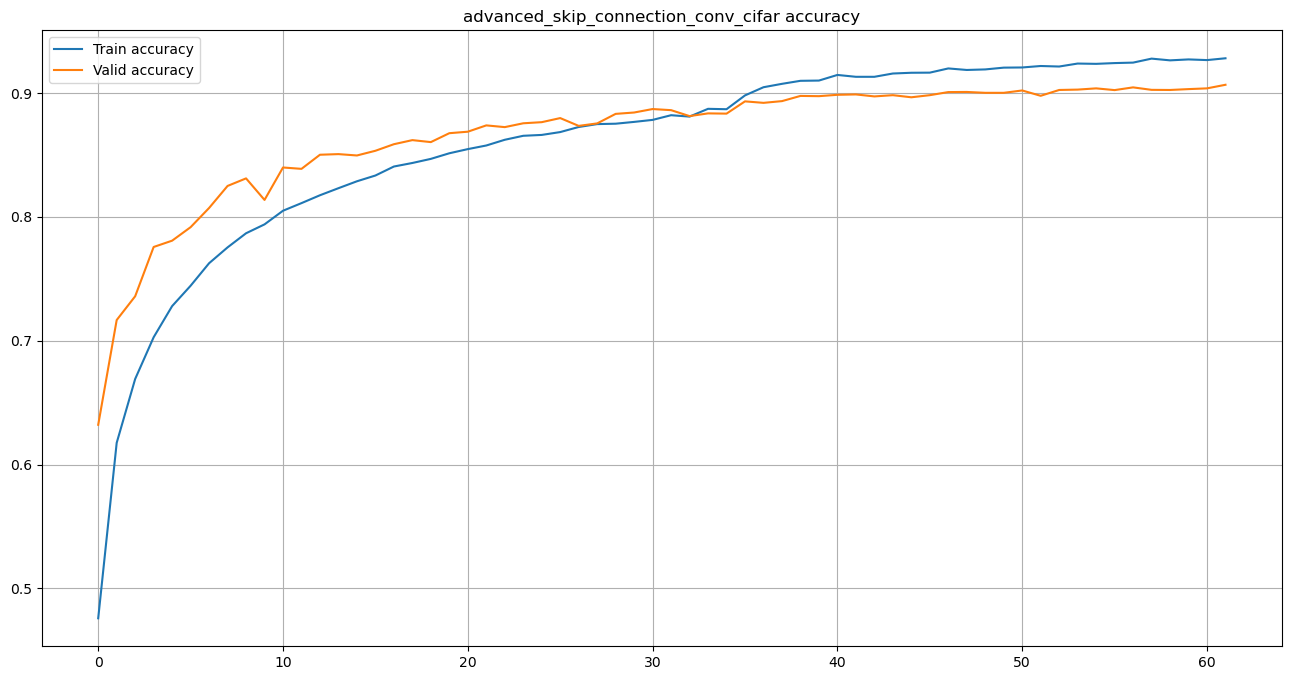

Files already downloaded and verified


In [26]:
title = 'advanced_skip_connection_conv_cifar'
threshold = 0.905

set_seed(0xDEADF00D)

dataset = CIFAR10("cifar10", train=True, download=True, transform=T.ToTensor())

means = (dataset.data / 255).mean(axis=(0, 1, 2))
stds = (dataset.data / 255).std(axis=(0, 1, 2))

train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds),
    ]
)

test_transforms = T.Compose([T.ToTensor(), T.Normalize(mean=means, std=stds)])

dataset_train = CIFAR10(
    "cifar10", train=True, download=True, transform=train_transforms
)
dataset_valid = CIFAR10(
    "cifar10", train=False, download=True, transform=test_transforms
)

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_advanced_skip_connection_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=35, gamma=0.2)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
)

torch.save(model.state_dict(), "model_905.pt")

dataset_valid_tta = CIFAR10("cifar10", train=False, download=True, transform=train_transforms)
valid_tta_loader = DataLoader(dataset_valid_tta, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

torch.save(predict_tta(model, valid_tta_loader, device, iterations=20), "prediction_tta_905.pt")

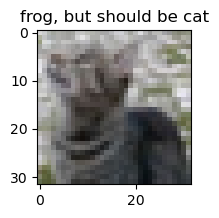

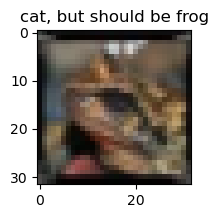

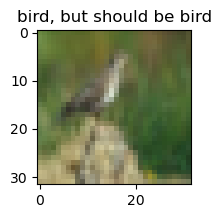

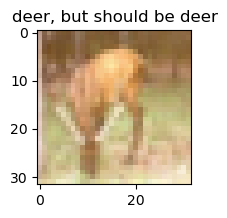

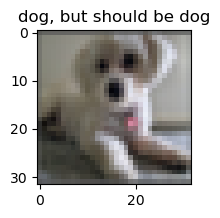

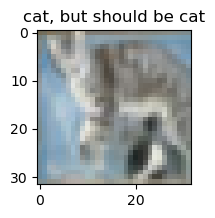

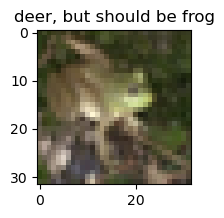

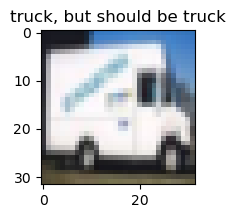

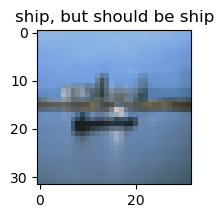

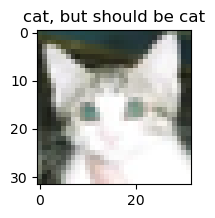

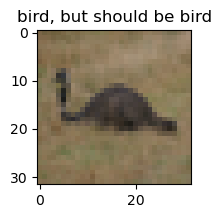

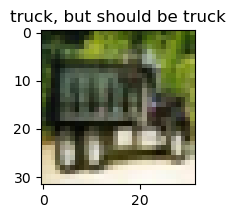

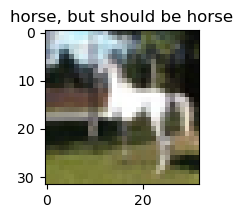

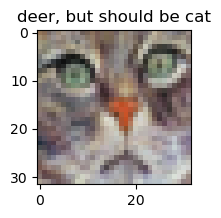

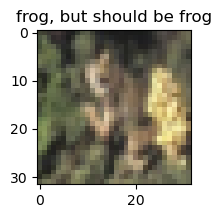

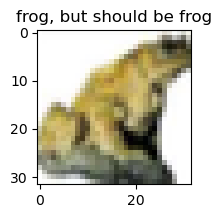

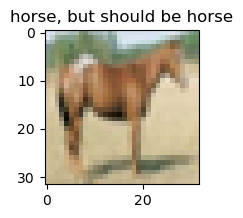

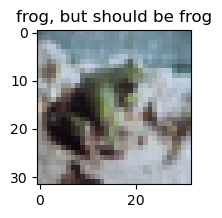

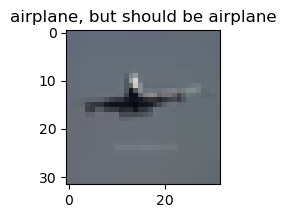

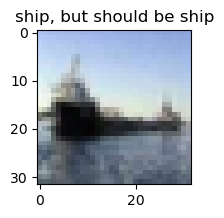

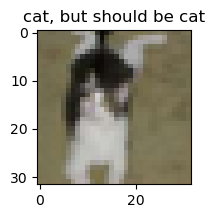

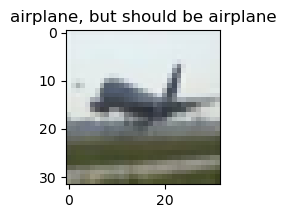

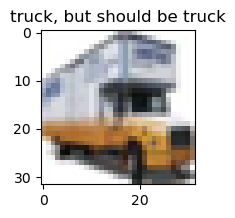

In [27]:
for x in range(333,10000,437):
   check_cifar(x)